In [3]:
## IMPORTS
import xlwt , xlrd
from xlwt import Workbook
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from keras.layers import Activation, Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D 
from keras.optimizers import SGD
from keras import optimizers
import tensorflow as tf
from tflearn.layers.core import dropout

In [26]:
## Connect to Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Workbook is created
wb = Workbook()

# Add_sheet database.
sheet1 = wb.add_sheet('database')
# Drive link
rootdir = r'/content/drive/MyDrive/pattern/dataset'
# Excel headers
sheet1.write(0, 0, 'ID')
sheet1.write(0, 1, 'CLASS')
i=1
val=0
IMG_SIZE=100
imgs=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
      ## Take the path of the image
        img_path=(os.path.join(subdir, file))
        img=cv2.imread(img_path)
        img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
        imgs.append(img)
        ## Append the class in the excel file
        sheet1.write(i, 0, i)
        sheet1.write(i, 1, val-1)
        i=i+1
    val=val+1

wb.save('database.xls')

In [5]:
## Convert lists to numpay arrays
X_data= imgs
y=[]
loc = ("/content/database.xls")
 
wb = xlrd.open_workbook(loc)
sheet = wb.sheet_by_index(0)
 
# For row 0 and column 0
sheet.cell_value(0, 0)
for i in range(1,sheet.nrows):
    y.append((sheet.cell_value(i, 1)))
Y_data=np.array(y)
## Save the data to load it after first run
np.save('X_data1',X_data)
np.save('Y_data1',Y_data)

In [4]:
## Load data
X_data = np.load(r'/content/drive/MyDrive/pattern/X_data1.npy')
Y_data = np.load(r'/content/drive/MyDrive/pattern/Y_data1.npy')

In [5]:
## Normalize image data
X_data = X_data / 255.0

In [18]:
## Divide the Data ( 70% train , 15% validation, 15% test) in shuffle 
X_train, X_test, y_train, y_test = train_test_split(X_data,Y_data, test_size=0.3, shuffle=True)
X_test, X_validate, y_test,y_validate = train_test_split(X_test,y_test, test_size=0.5, shuffle=True)

In [19]:
## Use a Sequential model with (two 32Conv2d-layers)and their normalization and maxpooling then (two 64Conv2d-layers)and their normalization and maxpooling) then dropout 20%
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

###########
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 64)       

In [20]:
# Flatten the model and add 128 dense with 11 classes and activation function "softmax"
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(11))
model.add(Activation("softmax"))
#############
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 64)       

In [21]:
## using SGD function with learning rate 0.001 and momentum 0.9 as an optimizer and using Categoricalcrossentropy as loss function from keras
## fit the model with 30 epoches and batch size 64
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_validate, y_validate))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Train on 2343 samples, validate on 503 samples
Epoch 1/30
2343/2343 [==============================] - 2s 810us/sample - loss: 2.1942 - acc: 0.2761 - val_loss: 1.6471 - val_acc: 0.4573


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 2/30
2343/2343 [==============================] - 2s 729us/sample - loss: 1.1325 - acc: 0.6368 - val_loss: 1.0841 - val_acc: 0.6740
Epoch 3/30
2343/2343 [==============================] - 2s 724us/sample - loss: 0.4996 - acc: 0.8438 - val_loss: 0.6895 - val_acc: 0.7952
Epoch 4/30
2343/2343 [==============================] - 2s 728us/sample - loss: 0.2161 - acc: 0.9351 - val_loss: 0.4436 - val_acc: 0.8847
Epoch 5/30
2343/2343 [==============================] - 2s 725us/sample - loss: 0.0679 - acc: 0.9825 - val_loss: 0.4265 - val_acc: 0.9145
Epoch 6/30
2343/2343 [==============================] - 2s 731us/sample - loss: 0.0200 - acc: 0.9957 - val_loss: 0.4320 - val_acc: 0.9245
Epoch 7/30
2343/2343 [==============================] - 2s 736us/sample - loss: 0.0123 - acc: 0.9974 - val_loss: 0.4196 - val_acc: 0.9324
Epoch 8/30
2343/2343 [==============================] - 2s 732us/sample - loss: 0.0062 - acc: 0.9991 - val_loss: 1.1508 - val_acc: 0.8270
Epoch 9/30
2343/2343 [============

In [22]:
## evaluate results with test data ( X, Y)
results = model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

test loss, test acc: [0.3379521191832554, 0.9402391]


In [31]:
## Use online open source " Alex model " to compare the results
model_Alex = models.Sequential()

# 1st Convolutional Layer
model_Alex.add(layers.Conv2D(filters = 96, input_shape = (100, 100, 3),
			kernel_size = (11, 11), strides = (4, 4),
			padding = 'same'))
model_Alex.add(Activation('relu'))
# Max-Pooling
model_Alex.add(layers.MaxPooling2D(pool_size = (2, 2),
			strides = (2, 2), padding = 'same'))
# Batch Normalisation
model_Alex.add(layers.BatchNormalization())

# 2nd Convolutional Layer
model_Alex.add(layers.Conv2D(filters = 256, kernel_size = (11, 11),
			strides = (1, 1), padding = 'same'))
model_Alex.add(Activation('relu'))
# Max-Pooling
model_Alex.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2),
			padding = 'same'))
# Batch Normalisation
model_Alex.add(layers.BatchNormalization())

# 3rd Convolutional Layer
model_Alex.add(layers.Conv2D(filters = 384, kernel_size = (3, 3),
			strides = (1, 1), padding = 'same'))
model_Alex.add(Activation('relu'))
# Batch Normalisation
model_Alex.add(layers.BatchNormalization())

# 4th Convolutional Layer
model_Alex.add(layers.Conv2D(filters = 384, kernel_size = (3, 3),
			strides = (1, 1), padding = 'same'))
model_Alex.add(Activation('relu'))
# Batch Normalisation
model_Alex.add(layers.BatchNormalization())

# 5th Convolutional Layer
model_Alex.add(layers.Conv2D(filters = 256, kernel_size = (3, 3),
			strides = (1, 1), padding = 'same'))
model_Alex.add(Activation('relu'))
# Max-Pooling

model_Alex.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2),
			padding = 'same'))
# Batch Normalisation
model_Alex.add(layers.BatchNormalization())

# Flattening
model_Alex.add(layers.Flatten())

# 1st layers.Dense Layer
model_Alex.add(layers.Dense(4096, input_shape = (100*100*3, )))
model_Alex.add(Activation('relu'))
# Add Dropout to prevent overfitting
model_Alex.add(layers.Dropout(0.4))
# Batch Normalisation
model_Alex.add(layers.BatchNormalization())

# 2nd layers.Dense Layer
model_Alex.add(layers.Dense(4096))
model_Alex.add(Activation('relu'))
# Add Dropout
model_Alex.add(layers.Dropout(0.4))
# Batch Normalisation
model_Alex.add(layers.BatchNormalization())

# Output Softmax Layer
model_Alex.add(layers.Dense(11))
model_Alex.add(Activation('softmax'))


In [32]:
## using SGD function with learning rate 0.001 and momentum 0.9 as an optimizer and using Categoricalcrossentropy as loss function from keras
## fit the model with 30 epoches and batch size 64
opt = SGD(lr=0.001, momentum=0.9)
model_Alex.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history = model_Alex.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_validate, y_validate))

Train on 2343 samples, validate on 503 samples
Epoch 1/30
2343/2343 [==============================] - ETA: 0s - loss: 3.2665 - acc: 0.2668

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2343/2343 [==============================] - 6s 2ms/sample - loss: 3.2665 - acc: 0.2668 - val_loss: 181.9187 - val_acc: 0.0875
Epoch 2/30
2343/2343 [==============================] - 2s 955us/sample - loss: 1.9991 - acc: 0.4289 - val_loss: 21.1177 - val_acc: 0.1471
Epoch 3/30
2343/2343 [==============================] - 2s 959us/sample - loss: 1.5737 - acc: 0.5493 - val_loss: 12.4452 - val_acc: 0.1968
Epoch 4/30
2343/2343 [==============================] - 2s 957us/sample - loss: 1.1906 - acc: 0.6462 - val_loss: 5.6776 - val_acc: 0.3062
Epoch 5/30
2343/2343 [==============================] - 2s 966us/sample - loss: 1.1118 - acc: 0.6846 - val_loss: 1.3096 - val_acc: 0.5924
Epoch 6/30
2343/2343 [==============================] - 2s 952us/sample - loss: 0.7265 - acc: 0.7870 - val_loss: 4.2074 - val_acc: 0.4950
Epoch 7/30
2343/2343 [==============================] - 2s 956us/sample - loss: 0.5844 - acc: 0.8224 - val_loss: 2.4332 - val_acc: 0.5785
Epoch 8/30
2343/2343 [=====================

In [33]:
## evaluate results with test data ( X, Y)
results = model_Alex.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

test loss, test acc: [0.37000213462518033, 0.9302789]


/content/drive/MyDrive/pattern/Objects/butterfly.jpg
Class: [8]      **butterfly**


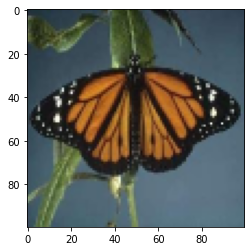

/content/drive/MyDrive/pattern/Objects/cannon.jpg
Class: [9]      **cannon**


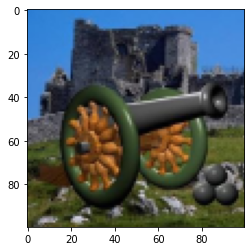

/content/drive/MyDrive/pattern/Objects/brontosaurus.jpg
Class: [7]      **bronotaus**


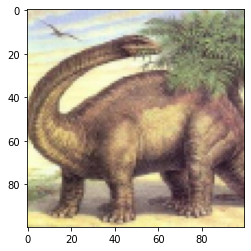

/content/drive/MyDrive/pattern/Objects/brain.jpg
Class: [6]      **brain**


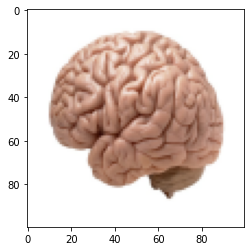

/content/drive/MyDrive/pattern/Objects/bonasi.jpg
Class: [5]      **bonasi**


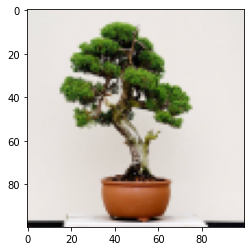

/content/drive/MyDrive/pattern/Objects/binocular.jpg
Class: [5]      **bonasi**


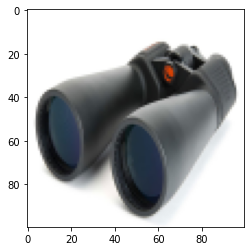

/content/drive/MyDrive/pattern/Objects/beaver.jpeg
Class: [3]      **beaver**


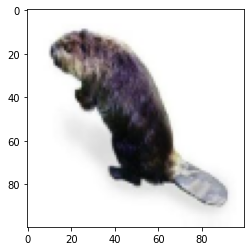

/content/drive/MyDrive/pattern/Objects/bass.jpg
Class: [2]      **bass**


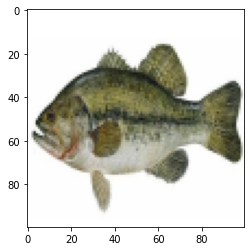

/content/drive/MyDrive/pattern/Objects/barrel.jpg
Class: [1]      **barrel**


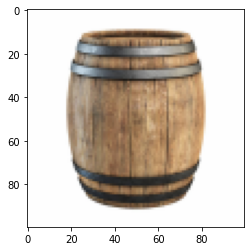

/content/drive/MyDrive/pattern/Objects/anchor.jpg
Class: [0]      **Anchor**


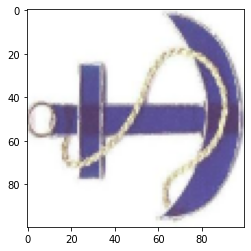

/content/drive/MyDrive/pattern/Objects/carside.jpg
Class: [10]      **carside**


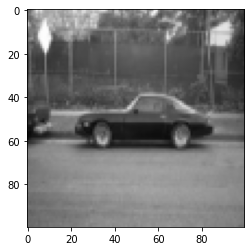

In [61]:
## Add image from each class downloaded from the internet in Drive. and start testing them
folder = r'/content/drive/MyDrive/pattern/Objects'

for filename in os.listdir(folder):
  img_path = (os.path.join(folder,filename))
  print(img_path)
  img = (cv2.imread(img_path))
  img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (100,100), interpolation = cv2.INTER_AREA)
  X_pred = np.reshape(img,(1,img.shape[0],img.shape[1],3))
  y_pred = model.predict(X_pred)
  y_pred = np.argmax(y_pred, axis = 1)
  if y_pred==0:
    coressponding_class='**Anchor**'
  elif y_pred==1:
    coressponding_class='**barrel**'
  elif y_pred==2:
    coressponding_class='**bass**'
  elif y_pred==3:
    coressponding_class='**beaver**'
  elif y_pred==4:
    coressponding_class='**binocular**'
  elif y_pred==5:
    coressponding_class='**bonasi**'
  elif y_pred==6:
    coressponding_class='**brain**'
  elif y_pred==7:
    coressponding_class='**bronotaus**'
  elif y_pred==8:
    coressponding_class='**butterfly**'
  elif y_pred==9:
    coressponding_class='**cannon**'
  else:
    coressponding_class='**carside**'

  plt.imshow(img)
  print('Class:',y_pred,'    ',coressponding_class)
  plt.show()

############################################ Classes #########################
##     carside        ----->10
##
##     cannon         ------>9
##
##     butterfly      ------>8    
##
##     bronotaus      ------>7     
##
##     brain          ------>6     
##
##     bonasi         ------>5     
##
##     binocular      ------>4   
##
##     beaver         ------>3    
##
##     bass           ------>2     
##
##     barrel         ------>1
##
##     anchor         ------>0